<a href="https://colab.research.google.com/github/parsa-abbasi/Sentiment-Analysis/blob/master/Binary-Classification/DL_KerasEmb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Requirements

## Install required libraries

In [2]:
!pip install hazm
!pip install stopwords_guilannlp
!pip install matplotlib==3.1.0

     |████████████████████████████████| 317kB 6.7MB/s 
     |████████████████████████████████| 235kB 45.4MB/s 
     |████████████████████████████████| 1.4MB 48.0MB/s 
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp36-cp36m-linux_x86_64.whl size=154316 sha256=892cb4a928a8628f4cc7fb0c157eb1f26548c8ad67bf557f377e9af26ae8a685
  Stored in directory: /root/.cache/pip/wheels/66/15/54/4510dce8bb958b1cdd2c47425cbd1e1eecc0480ac9bb1fb9ab
  Created wheel for nltk: filename=nltk-3.3-cp36-none-any.whl size=1394467 sha256=4410b69b668ad987dfae85ab49a75e5db19d265e5e9f7821d0abbaf248184e40
  Stored in directory: /root/.cache/pip/wheels/d1/ab/40/3bceea46922767e42986aef7606a600538ca80de6062dc266c
Successfully built libwapiti nltk
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5
     |████████████████████████████████| 13.1MB 5.5MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which

## Import Libraries

In [3]:
# General
import numpy as np
import pandas as pd
import codecs
from google.colab import files
# Keras
from keras import optimizers
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Embedding, Dropout
from keras.layers import GlobalMaxPool1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import CuDNNLSTM, LSTM, Bidirectional
from keras.layers.convolutional import Conv1D
from keras.utils.np_utils import to_categorical
from keras.metrics import categorical_accuracy
from keras.utils import plot_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# Preprocessing
from stopwords_guilannlp import stopwords_output
from hazm import *
# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
from keras.utils import plot_model

Using TensorFlow backend.


# Upload dataset files

Upload dataset files to colab environment

You can access to dataset files through following links:

(x_train, x_test, y_train, y_test)
- [Original dataset](https://github.com/parsa-abbasi/Sentiment-Analysis/tree/master/Dataset/Original)
- [Balanced with extra data](https://github.com/parsa-abbasi/Sentiment-Analysis/tree/master/Dataset/BalancedWithExtra)
- [Data Augmentation - Full Translate](https://github.com/parsa-abbasi/Sentiment-Analysis/tree/master/Dataset/FullTranslate)
- [Data Augmentation - Synonyms](https://github.com/parsa-abbasi/Sentiment-Analysis/tree/master/Dataset/Synonyms)

In [4]:
from google.colab import files
uploaded = files.upload()

Saving x_test.csv to x_test.csv
Saving x_train.csv to x_train.csv
Saving y_test.csv to y_test.csv
Saving y_train.csv to y_train.csv



# Import & Analyze Dataset

In [0]:
x_train = pd.read_csv('x_train.csv', sep='\t', index_col=None, header=None, encoding="utf-8")[1]
x_test = pd.read_csv('x_test.csv', sep='\t', index_col=None, header=None, encoding="utf-8")[1]
y_train = pd.read_csv('y_train.csv', sep='\t', index_col=None, header=None)[1]
y_test = pd.read_csv('y_test.csv', sep='\t', index_col=None, header=None)[1]

In [0]:
# The dataset csv files created using old version of Pandas
# so we need to do some additional preparation
x_train = x_train[1:]
x_train = x_train.reset_index(drop=True)
x_test = x_test[1:]
x_test = x_test.reset_index(drop=True)
y_train = y_train[1:]
y_train = y_train.reset_index(drop=True)
y_test = y_test[1:]
y_test = y_test.reset_index(drop=True)

In [7]:
print('Number of training sentence: ', x_train.shape)
print('Number of training label: ', y_train.shape)
print('Number of testing sentence: ', x_test.shape)
print('Number of testing label: ', y_test.shape)

Number of training sentence:  (7023,)
Number of training label:  (7023,)
Number of testing sentence:  (1854,)
Number of testing label:  (1854,)


Remove *neutral* sentences from the dataset

In [0]:
binary_y_train = []
binary_y_test = []
binary_x_train = []
binary_x_test = []
for i, y in enumerate(y_train):
  if y != 0:
    if y > 0:
      binary_y_train.append(1)
      binary_x_train.append(x_train[i])
    else:
      binary_y_train.append(0)
      binary_x_train.append(x_train[i])
      
for i, y in enumerate(y_test):
  if y != 0:
    if y > 0:
      binary_y_test.append(1)
      binary_x_test.append(x_test[i])
    else:
      binary_y_test.append(0)
      binary_x_test.append(x_test[i])

In [0]:
# Convert dataframes to numpy arrays
x_train = np.asarray(binary_x_train)
x_test = np.asarray(binary_x_test)
y_train = np.asarray(binary_y_train)
y_test = np.asarray(binary_y_test)

In [10]:
# See the data number of sentence in each category 
from collections import Counter
cnt = Counter(y_train)
cnt = dict(cnt)
print(cnt)

{1: 3928, 0: 1095}


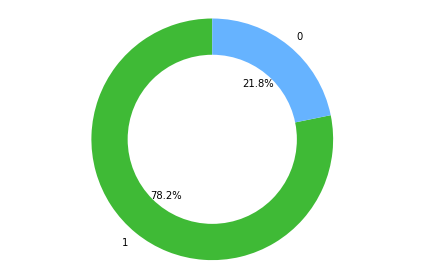

In [12]:
labels = list(cnt.keys())
sizes = list(cnt.values())
colors = ['#3fba36', '#66b3ff','#ffcc99','#ff9999', '#d44444']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
# Decomment following line if you want to save the figure
# plt.savefig('balanced_with_extra_binary.png')
plt.show()

In [0]:
# Decomment following line if you want to download dataset figure
# files.download('balanced_with_extra_binary.png')

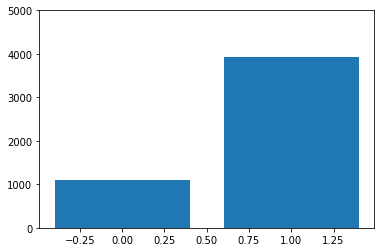

In [19]:
plt.bar(labels[::-1], sizes[::-1], width=0.8, bottom=None, align='center')
plt.ylim([0, 5000])
# plt.savefig('bar_balanced_with_extra_binary.png')

In [0]:
# Decomment following line if you want to download dataset figure
# files.download('bar_balanced_with_extra_binary.png')

# Preprocess

In [0]:
# Customize preprocessing
puncs = ['،', '.', ',', ':', ';', '"']

# Hazm library
normalizer = Normalizer()
lemmatizer = Lemmatizer()

# Apply preprocessing to a document
def clean_doc(doc):
  # Normalize document
  doc = normalizer.normalize(doc)
  # Tokenize text
  tokenized = word_tokenize(doc)
  # Remove punctuation
  tokens = []
  for t in tokenized:
    temp = t
    for p in puncs:
      temp = temp.replace(p, '')
    if temp.isdigit():
      tokens.append('<DIGIT>')
    else:
      tokens.append(temp)
  # Remove stop words
  # tokens = [w for w in tokens if not w in stop_set]
  # Remove one length words
  tokens = [w for w in tokens if not len(w) <= 1]
  # Remove digits
  #tokens = [w for w in tokens if not w.isdigit()]
  # Lemmatize sentence words using Hazm Lemmatizer
  tokens = [lemmatizer.lemmatize(w) for w in tokens]
  # Merge tokens to a single string
  tokens = ' '.join(tokens)
  return tokens

# Prepare data for Deep Learning model

## Apply preprocessing to data

In [0]:
# Apply preprocessing step to training data
train_docs = np.empty_like(x_train)
for index, document in enumerate(x_train):
  train_docs[index] = clean_doc(document)

In [0]:
# Applying preprocessing step to test data
test_docs = np.empty_like(x_test)
for index, document in enumerate(x_test):
  test_docs[index] = clean_doc(document)

## Setting tokenizer up

In [0]:
num_words = 2500

# Create the tokenizer
tokenizer = Tokenizer()

# fFt the tokenizer on the training documents
tokenizer.fit_on_texts(train_docs)

In [0]:
# Find maximum length of training sentences
max_length = max([len(s.split()) for s in train_docs])

## Embed sentences

In [0]:
# Embed training sequences
encoded_docs = tokenizer.texts_to_sequences(train_docs)

# Pad embeded training sequences
x_train_padded = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [0]:
# Define vocabulary size (largest integer value)
vocab_size = len(tokenizer.word_index)

In [0]:
# Embed testing sequences
encoded_docs = tokenizer.texts_to_sequences(test_docs)
# Pad testing sequences
x_test_padded = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

# Deep Learning Models

## B-LSTM Model

In [40]:
model_blstm = Sequential()
model_blstm.add(Embedding(vocab_size, 500, input_length=max_length))
model_blstm.add(Bidirectional(CuDNNLSTM(500, return_sequences=True, name='lstm_layer')))
model_blstm.add(GlobalMaxPool1D())
model_blstm.add(Dropout(0.1))
model_blstm.add(Dense(500, activation="relu"))
model_blstm.add(Dropout(0.1))
model_blstm.add(Dense(1, activation='sigmoid'))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [41]:
model_blstm.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_blstm.summary()
batch_size_blstm = 32
epochs_blstm = 3



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 259, 500)          2965000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 259, 1000)         4008000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 1000)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               500500    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0         
________________________

In [42]:
# Train model
hist_blstm = model_blstm.fit(x_train_padded, y_train, batch_size=batch_size_blstm, epochs=epochs_blstm)




Epoch 1/3





5023/5023 [==============================] - 24s 5ms/step - loss: 0.4284 - acc: 0.8097
Epoch 2/3
5023/5023 [==============================] - 15s 3ms/step - loss: 0.2450 - acc: 0.9026
Epoch 3/3
5023/5023 [==============================] - 15s 3ms/step - loss: 0.1248 - acc: 0.9554


In [43]:
# Evaluate model
loss_blstm, acc_blstm = model_blstm.evaluate(x_test_padded, y_test, verbose=0)
print('Test Accuracy: %f' % (acc_blstm*100))

Test Accuracy: 92.439244


In [0]:
# Get prediction label
y_pred_blstm = model_blstm.predict_classes(x_test_padded[:-1])

## CNN Model

In [45]:
model_cnn = Sequential()
model_cnn.add(Embedding(vocab_size, 2000, input_length=max_length))
model_cnn.add(Conv1D(filters=64, kernel_size=4, activation='relu', padding='same'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Conv1D(filters=64, kernel_size=8, activation='relu', padding='same'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Conv1D(filters=64, kernel_size=16, activation='relu', padding='same'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dropout(0.1))
model_cnn.add(Dense(2000, activation="sigmoid"))
model_cnn.add(Dense(1, activation='sigmoid'))

In [46]:
model_cnn.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_cnn.summary()
batch_size_cnn = 64
epochs_cnn = 5

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 259, 2000)         11860000  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 259, 64)           512064    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 129, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 129, 64)           32832     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 64, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 64, 64)            65600     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)               

In [47]:
# Train model
hist_cnn = model_cnn.fit(x_train_padded, y_train, batch_size=batch_size_cnn, epochs=epochs_cnn)

Epoch 1/5
5023/5023 [==============================] - 4s 744us/step - loss: 0.5423 - acc: 0.7744
Epoch 2/5
5023/5023 [==============================] - 2s 442us/step - loss: 0.3906 - acc: 0.8280
Epoch 3/5
5023/5023 [==============================] - 2s 441us/step - loss: 0.1571 - acc: 0.9439
Epoch 4/5
5023/5023 [==============================] - 2s 444us/step - loss: 0.0612 - acc: 0.9807
Epoch 5/5
5023/5023 [==============================] - 2s 444us/step - loss: 0.0257 - acc: 0.9918


In [48]:
# Evaluate model
loss_cnn, acc_cnn = model_cnn.evaluate(x_test_padded, y_test, verbose=0)
print('Test Accuracy: %f' % (acc_cnn*100))

Test Accuracy: 90.459046


In [0]:
# Get prediction label
y_pred_cnn = model_cnn.predict_classes(x_test_padded[:-1])

# Confusion Matrix

In [0]:
y_test_label = []
for counter in range(0, len(categorical_y_test)-1):
  label = np.argmax(categorical_y_test[:-1][counter])
  y_test_label.append(label)
y_test_label = np.array(y_test_label)

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    print(im)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

class_names = np.array([0, 1])
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[165  31]
 [ 53 861]]
AxesImage(54,36;334.8x217.44)
Normalized confusion matrix
[[0.84 0.16]
 [0.06 0.94]]
AxesImage(54,36;334.8x217.44)


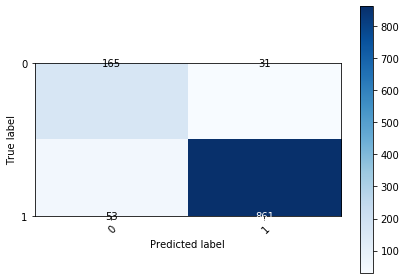

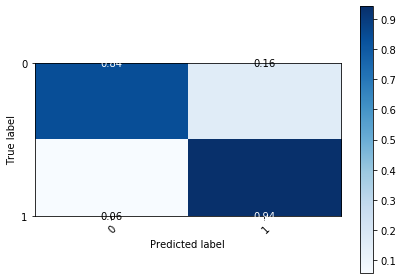

In [60]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_label, y_pred_blstm, classes=class_names)
plt.savefig('cm-blstm.png')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test_label, y_pred_blstm, classes=class_names, normalize=True)
# Decomment following line if you want to save the figure
plt.savefig('cm-blstm-normalized.png')
plt.show()

In [0]:
# Decomment following line if you want to download confusion matrix figure
# files.download('cm-blstm.png')
# files.download('cm-blstm-normalized.png')

Confusion matrix, without normalization
[[165  31]
 [ 75 839]]
AxesImage(54,36;334.8x217.44)
Normalized confusion matrix
[[0.84 0.16]
 [0.08 0.92]]
AxesImage(54,36;334.8x217.44)


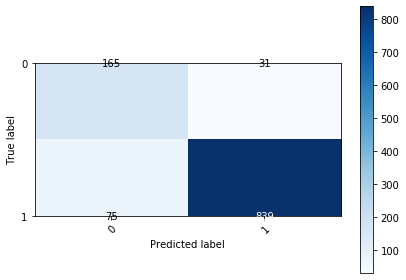

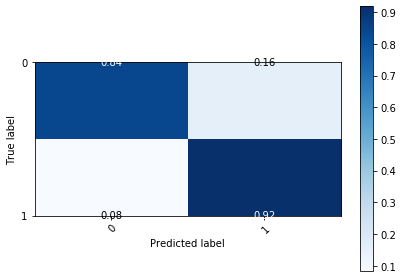

In [62]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_label, y_pred_cnn, classes=class_names)
plt.savefig('cm-cnn.png')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test_label, y_pred_cnn, classes=class_names, normalize=True)
plt.savefig('cm-cnn-normalized.png')
plt.show()

In [0]:
# Decomment following line if you want to download confusion matrix figure
# files.download('cm-cnn.png')
# files.download('cm-cnn-normalized.png')

# Model Visualization

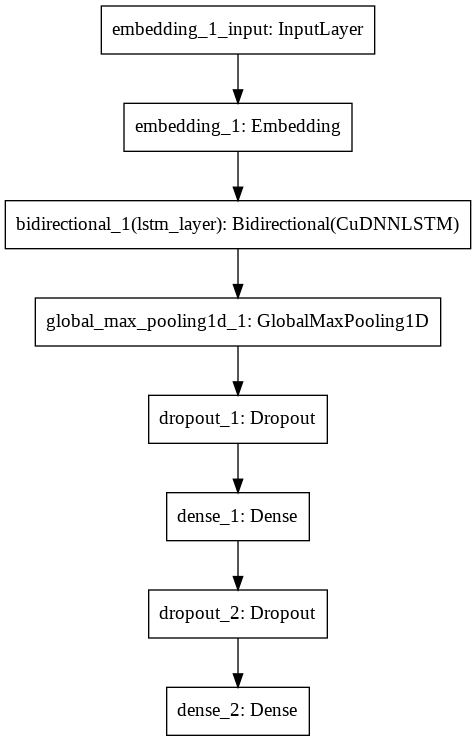

In [64]:
plot_model(model_blstm, to_file='binary-blstm.png')

In [0]:
# Decomment following line if you want to download model figure
# files.download('binary-blstm.png')

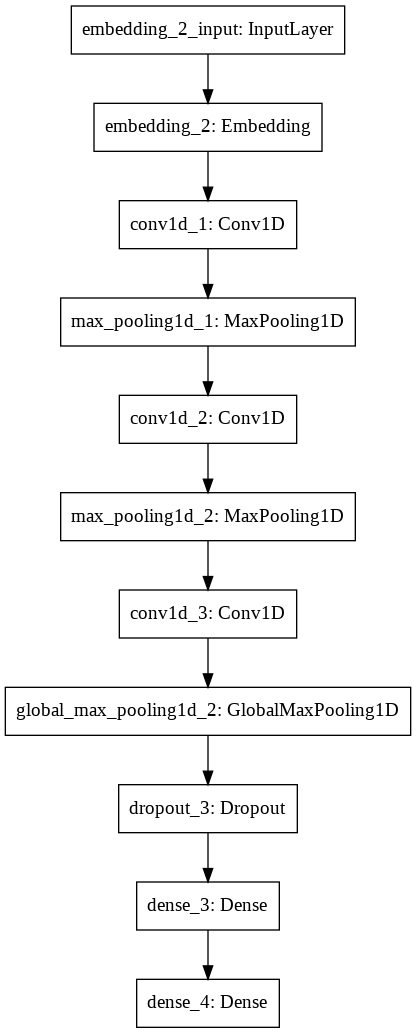

In [66]:
plot_model(model_cnn, to_file='binary-cnn.png')

In [0]:
# Decomment following line if you want to download model figure
# files.download('binary-cnn.png')